## Airlines Price Discrimination — Part 2: Exploratory Data Analysis

This notebook explores airline market dynamics using the prepared dataset Airports_data_ready.csv. The focus is to understand how competition, market concentration, and carrier structure relate to average fares and passenger volumes.


Here, I 
* Examine dataset structure, key variables, and data quality, including missing values, duplicates, and outliers.
* Analyze market concentration using the Herfindahl–Hirschman Index (HHI) and the number of carriers per route.
* Visualize how fares relate to competition intensity and market characteristics, such as small versus large markets and carrier dominance patterns.
* Evaluate correlations and multicollinearity among price, demand, and structural variables to identify reliable predictors for further modeling.

The goal is to uncover patterns that inform how pricing varies with competition intensity, market size, and carrier composition—laying the foundation for later econometric and causal analysis on airline price discrimination.

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm


warnings.filterwarnings("ignore")

### II. Data Loading & Initial Checks

In [9]:
data = pd.read_pickle("../data/Airlines_tickets_data_ready.pkl")
print(data.shape)
data.head()

(2297983, 85)


,origin,finaldest,return,year,quarter,airports,return_sym,stops,avgprice,passengers,...,city_D,state_D,county_D,type_D,airport_O1,city_O1,state_O1,airport_D1,city_D1,state_D1
0,ABE,ABI,1,2010,2,7,1.0,2,530.0,1,...,Abilene,NaN,NaN,AP,ABE,Allentown,PA,ABI,Abilene,TX
1,ABE,ABI,1,2010,3,7,0.0,2,822.5,2,...,Abilene,NaN,NaN,AP,ABE,Allentown,PA,ABI,Abilene,TX
2,ABE,ABI,1,2010,4,7,1.0,2,389.5,2,...,Abilene,NaN,NaN,AP,ABE,Allentown,PA,ABI,Abilene,TX
3,ABE,ABI,1,2011,1,7,1.0,2,381.0,1,...,Abilene,NaN,NaN,AP,ABE,Allentown,PA,ABI,Abilene,TX
4,ABE,ABI,1,2011,3,7,1.0,2,1096.0,1,...,Abilene,NaN,NaN,AP,ABE,Allentown,PA,ABI,Abilene,TX


See readme-airline-tickets-ready-data.txt for full variable descriptions and dataset details.

In [10]:
data.columns

Index(['origin', 'finaldest', 'return', 'year', 'quarter', 'airports',
       'return_sym', 'stops', 'avgprice', 'passengers', 'itinfare',
       'sharelargest', 'share16', 'share9E', 'share9L', 'shareAA', 'shareAS',
       'shareB6', 'shareCO', 'shareCP', 'shareCS', 'shareDL', 'shareEV',
       'shareF8', 'shareF9', 'shareFL', 'shareG4', 'shareG7', 'shareHA',
       'shareL3', 'shareMQ', 'shareNK', 'shareOH', 'shareOO', 'shareOW',
       'shareQX', 'shareRP', 'shareS5', 'shareSY', 'shareU5', 'shareUA',
       'shareUS', 'shareVX', 'shareWN', 'shareXE', 'shareXJ', 'shareYV',
       'shareYX', 'shareZW', 'treated', 'smallmkt', 'code_O', 'icao_O',
       'name_O', 'latitude_O', 'longitude_O', 'elevation_O', 'url_O',
       'time_zone_O', 'city_code_O', 'country_O', 'city_O', 'state_O',
       'county_O', 'type_O', 'code_D', 'icao_D', 'name_D', 'latitude_D',
       'longitude_D', 'elevation_D', 'url_D', 'time_zone_D', 'city_code_D',
       'country_D', 'city_D', 'state_D', 'county_D', 'ty

### III.  Descriptive Statistics

I begin by summarizing key numeric variables (average fare, passengers, number of carriers, and stops) to understand the overall structure of airline routes.

In [19]:
route_comp = data.groupby('route')['carrier'].nunique().reset_index(name='n_carriers')
data = data.merge(route_comp, on='route')
num_cols_for_summary = [c for c in ['avgprice','passengers','n_carriers','stops'] if c in data.columns]
display(data[num_cols_for_summary].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T)

KeyError: 'route'

Average fares hover around $430, but with a wide spread some routes reach over $7,000, indicating strong variation by distance or market power. Passenger counts vary sharply too, with most routes carrying only a few dozen travelers but some exceeding 12,000. The average route has 3–4 carriers, though some have up to 24, suggesting highly competitive markets. Most flights involve no stops, confirming that direct connections dominate the dataset.

Next, I examine yearly averages for fares and passengers to capture broad trends.

In [16]:
group_targets = [c for c in ['avgprice','passengers'] if c in data.columns]
if len(group_targets) > 0:
    yearly = data.groupby('year')[group_targets].mean().round(2)
    display(yearly)

,avgprice,passengers
year,,
2010,385.929993,72.00
2011,415.510010,68.52
2012,431.980011,72.27
2013,436.339996,72.85
2014,446.010010,74.44
2015,444.790009,79.57
2016,435.510010,84.99


Between 2010 and 2016, both fares and passenger volumes generally increased, hinting at growing demand and possible consolidation in certain routes.

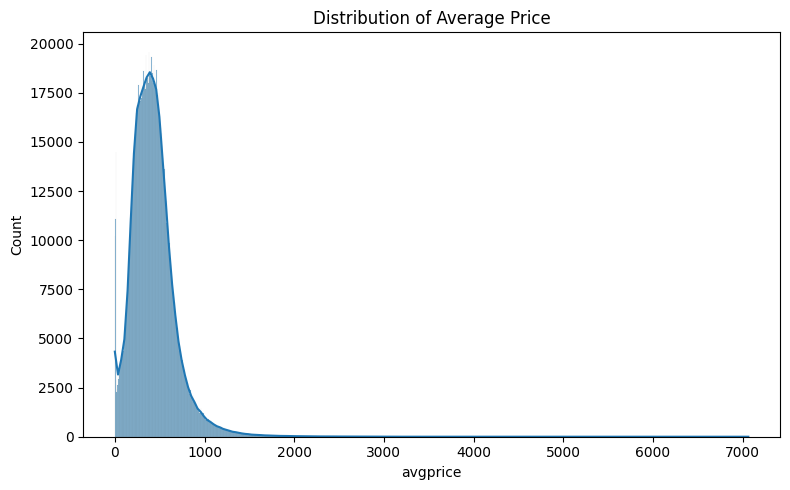

In [17]:
# visuals: distribution of average prices
plt.figure(figsize=(8,5))
sns.histplot(data['avgprice'].dropna(), kde=True, color='#1f77b4')
plt.title('Distribution of Average Price')
plt.xlabel('avgprice')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Distribution plot says that most U.S. air routes operate in a low-to-mid price range, but there are outliers where fares are much higher, hinting at potential market power or limited competition.

In [18]:
# Visuals: boxplots by number of carriers and by stops

# Boxplot by n_carriers
subset = data.copy()
if subset['n_carriers'].notna().any():
    upper_cap = subset['n_carriers'].dropna().quantile(0.99)
    subset = subset[subset['n_carriers'] <= upper_cap]
plt.figure(figsize=(10,5))
sns.boxplot(data=subset, x='n_carriers', y='avgprice')
plt.title('Average Price by Number of Carriers')
plt.xlabel('n_carriers')
plt.ylabel('avgprice')
plt.tight_layout()
plt.show()

# Boxplot by stops
plt.figure(figsize=(10,5))
sns.boxplot(data=data, x='stops', y='avgprice')
plt.title('Average Price by Number of Stops')
plt.xlabel('stops')
plt.ylabel('avgprice')
plt.tight_layout()
plt.show()


KeyError: 'n_carriers'

Average Price by Number of Carriers

As the number of carriers increases, average ticket prices decline sharply. Routes with fewer competitors (2–3 carriers) show higher fares and greater variability, reflecting stronger market power. In contrast, routes with six or more carriers display lower and more stable prices. This pattern highlights how competition effectively drives airfares down.

Average Price by Number of Stops

Ticket prices rise with the number of stops on a route. Nonstop flights are the cheapest and most consistent, while multi-stop itineraries are costlier and more variable. The trend reflects the added distance, time, and complexity of connecting routes, which naturally increase fares.

In [ ]:
# summary statistics for all columns
display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
return,2297983.0,0.545550,0.497921,0.000000,0.000000,1.000000,1.000000,1.000000e+00
year,2297983.0,2013.130966,1.959694,2010.000000,2011.000000,2013.000000,2015.000000,2.016000e+03
quarter,2297983.0,2.569188,1.091184,1.000000,2.000000,3.000000,4.000000,4.000000e+00
airports,2297983.0,4.351641,1.322057,2.000000,3.000000,5.000000,5.000000,9.000000e+00
return_sym,1253664.0,0.769353,0.421247,0.000000,1.000000,1.000000,1.000000,1.000000e+00
stops,2297983.0,1.165898,0.456911,0.000000,1.000000,1.000000,1.000000,3.000000e+00
avgprice,2297983.0,429.606876,247.119573,0.000000,269.000000,401.191930,542.333300,7.063000e+03
passengers,2297983.0,75.118182,341.760190,1.000000,2.000000,6.000000,24.000000,1.298500e+04
itinfare,2297983.0,14627.264569,49384.416089,0.000000,893.000000,2526.000000,8958.000000,3.419816e+06
sharelargest,2297983.0,0.771946,0.238111,0.111111,0.551231,0.833333,1.000000,1.000000e+00


The dataset spans 2010–2016, providing quarterly observations that capture consistent travel activity across U.S. routes. More than half of itineraries are round trips, and about 77% of those are symmetric, suggesting a mature and balanced air travel network structure.

When looking at airline representation, a few carriers stand out with consistently high market shares. Delta (DL) and its regional partners (EV, OO, MQ) account for a substantial portion of total capacity, while American (AA) and United (UA) also maintain strong nationwide presence. In contrast, low-cost carriers such as Southwest (WN) and Spirit (NK) appear far less frequently, confirming their limited route coverage compared to legacy networks.

The data also reveal that most routes are served by 3–4 airlines, yet variation remains wide — some smaller markets are effectively monopolized, while major corridors host over 20 competing carriers. This spread provides valuable ground for studying how competition intensity affects pricing and route strategy.

### IV. Market Analysis

To evaluate how competitive each airline route is, I construct two standard measures of market structure and add new variables for this part of analysis.

1. Compute HHI and Competition Proxies

In [ ]:
share_cols = [c for c in data.columns if c.startswith('share')]
shares = data[share_cols].copy()

max_share = shares.max().max()
scale_factor = 100.0 if max_share > 1 else 1.0
shares01 = shares / scale_factor

data['hhi'] = (shares01.pow(2)).sum(axis=1) * 10000

What it does:
* Identifies all columns representing airline market shares (e.g., shareAA, shareDL, etc.).
* Standardizes share values to a 0–1 scale (some datasets report in percentages).
* Computes the Herfindahl–Hirschman Index (HHI) — a measure of market concentration: HHI = sum (s_i^2) * 10000, 

where s_i is each airline’s market share on a route.


* Higher HHI → fewer dominant airlines (more concentrated market).
* Lower HHI → many small competitors (more competitive market).

2. Create Route Variable

In [ ]:
# create route variable
data['route'] = data['origin'] + '-' + data['finaldest']

What it does:

* Combines the origin and destination airports into a single route label (e.g., JAX-MEM).
* Defines the geographic market for analysis — the basic unit of competition.

3. Create Carrier Variable

In [ ]:
# create carrier variable
share_cols = [
    c for c in data.columns 
    if c.startswith('share') 
    and c not in ['sharelargest']
]
data['carrier'] = data[share_cols].idxmax(axis=1).str[-2:]

What it does:

* Finds which airline (carrier) has the largest share for each observation.
* Extracts the carrier code (e.g., AA, DL, WN).
* This variable represents the dominant carrier on each ticket record (the one most passengers flew with in that route’s market).
* `sharelargest` is excluded to ensure only actual carrier-specific columns are used.

4. Count Number of Carriers per Route

In [ ]:
# create n_carriers variable
route_comp = data.groupby('route')['carrier'].nunique().reset_index(name='n_carriers')
data = data.merge(route_comp, on='route')

What it does:
* Groups data by route and counts unique carriers operating on that route.
* Adds a new variable n_carriers = number of competing airlines on that route. (example: JAX–MEM might have 3 carriers (9E, DL, US))
* Helps analyze how competition (number of carriers) relates to prices.

5. Create 1/n_carriers Proxy Variable

In [ ]:
# create 1/n_carriers proxy variable (avoid division by zero)
if 'n_carriers' in data.columns:
    data['inv_n_carriers'] = np.where(data['n_carriers'] > 0, 1.0 / data['n_carriers'], np.nan)
else:
    data['inv_n_carriers'] = np.nan

What it does:

* Computes the inverse of carrier count (1 / n_carriers), often used as a competition proxy.
* Interpretation:
* Lower inv_n_carriers → more competitors → more competition.
* Higher inv_n_carriers → fewer competitors → less competition.
* Safely handles cases where n_carriers might be zero (avoiding division by zero errors).


In [ ]:
# Quick sanity check with more readable formatting (no scientific notation)
desc = data[['n_carriers','inv_n_carriers','hhi']].describe().copy()
desc = desc.applymap(lambda x: f"{x:,.2f}")
display(desc)

,n_carriers,inv_n_carriers,hhi
count,"2,297,983.00","2,297,983.00","2,297,983.00"
mean,4.48,0.33,"13,648.36"
std,2.42,0.25,"6,241.80"
min,1.00,0.06,"1,007.69"
25%,3.00,0.17,"7,500.00"
50%,4.00,0.25,"14,043.21"
75%,6.00,0.33,"20,000.00"
max,17.00,1.00,"20,000.00"


The descriptive summary provides a clear snapshot of competition across airline routes.
On average, each route is served by about 4 to 5 carriers, though this ranges from monopoly routes (1 carrier) to highly competitive markets with up to 17 carriers. The average HHI is 13,648, suggesting moderate concentration overall, while the wide range (1,000 to 20,000) indicates substantial variation between markets—from nearly perfect competition to near-monopolies. The inverse carrier count (mean ≈ 0.33) aligns with this pattern, confirming that most routes have several active airlines but still some highly concentrated segments dominated by a few major players.


* The mean HHI = 13,648 → typical U.S. routes in your data are highly concentrated, not perfectly competitive.
* The minimum HHI ≈ 1,000 → a small subset of routes exhibit almost perfect competition, meaning many airlines share passengers evenly.
* The maximum HHI = 20,000 → represents monopoly routes, where one carrier completely dominates that market.

In [ ]:
# Define thresholds based on HHI classification
competitive = data.query('hhi < 1500')
moderate = data.query('1500 <= hhi < 2500')
monopoly = data.query('hhi >= 10000')

# Quick sanity check — how many routes in each category
print("Highly competitive markets:", len(competitive))
print("Moderately concentrated markets:", len(moderate))
print("Monopoly / highly concentrated markets:", len(monopoly))

# Display some examples from each
display(competitive[['route', 'hhi', 'n_carriers', 'avgprice']].head(5))
display(moderate[['route', 'hhi', 'n_carriers', 'avgprice']].head(5))
display(monopoly[['route', 'hhi', 'n_carriers', 'avgprice']].head(5))

Highly competitive markets: 263
Moderately concentrated markets: 14219
Monopoly / highly concentrated markets: 1474149


,route,hhi,n_carriers,avgprice
64338,ALB-DFW,1374.631025,7,386.11980
127708,AUS-ANC,1493.158289,7,503.50960
166256,BDL-ANC,1475.694451,9,571.76390
167082,BDL-BOS,1322.222233,8,489.33334
167088,BDL-BOS,1373.456801,8,508.19446


,route,hhi,n_carriers,avgprice
741,ABE-BNA,2388.604766,9,353.21622
744,ABE-BNA,2471.606322,9,388.39536
1155,ABE-CAE,1944.444456,10,353.50000
1738,ABE-CVG,2309.356458,10,461.83722
1989,ABE-DEN,2353.395062,9,187.25000


,route,hhi,n_carriers,avgprice
0,ABE-ABI,20000.0,8,530.0
2,ABE-ABI,20000.0,8,389.5
3,ABE-ABI,20000.0,8,381.0
4,ABE-ABI,20000.0,8,1096.0
5,ABE-ABI,20000.0,8,899.0


The plot belows shows that routes with more carriers tend to have higher average fares, but this pattern likely reflects market size and distance, not lack of competition. It’s an important check that motivates deeper modeling using HHI instead of raw carrier counts.

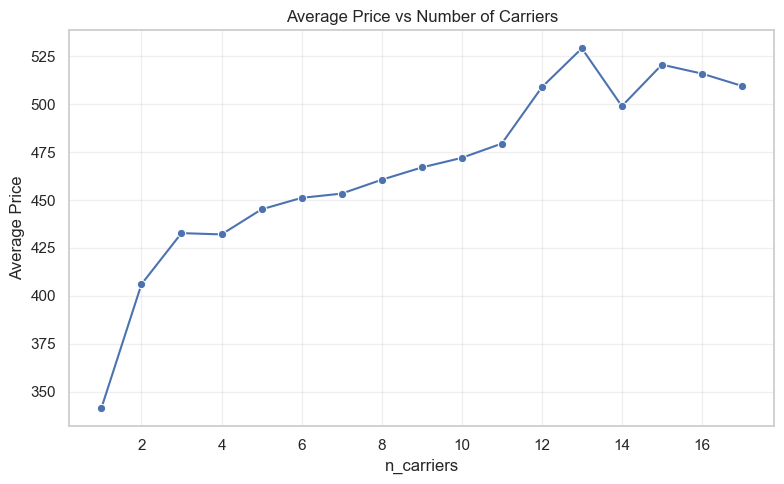

In [ ]:
# Visual: average price vs competition level (n_carriers)
agg = data.groupby('n_carriers', dropna=True)['avgprice'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.lineplot(data=agg, x='n_carriers', y='avgprice', marker='o')
plt.title('Average Price vs Number of Carriers')
plt.xlabel('n_carriers')
plt.ylabel('Average Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The previous plot (Average Price vs Number of Carriers) showed an unexpected positive trend: more carriers, higher fares.
The plot below compares a crude competition proxy (n_carriers) with a true economic measure of concentration—the HHI. By binning HHI, I smooth out noise and clearly show how fares vary across different market concentration levels.
Markets with greater concentration (higher HHI) do show higher average fares:

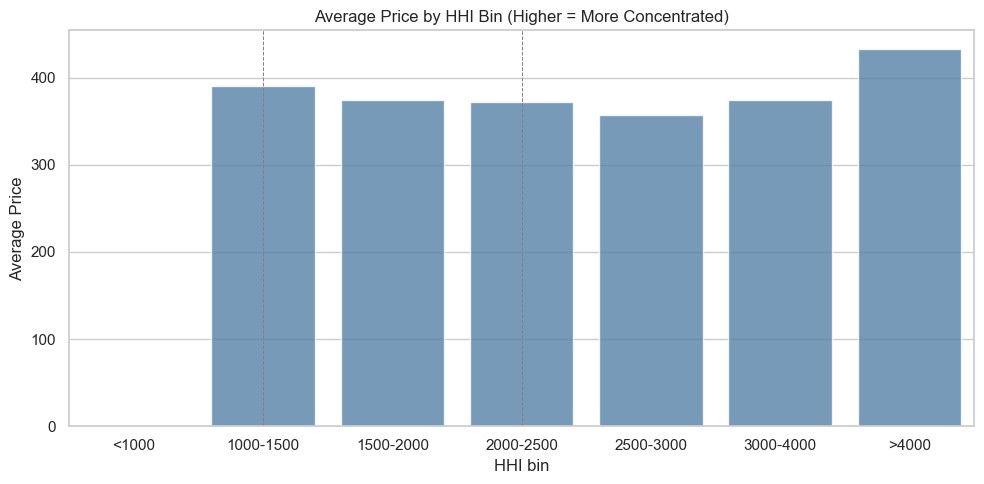

In [ ]:
bins = [0, 1000, 1500, 2000, 2500, 3000, 4000, np.inf]
labels = ['<1000','1000-1500','1500-2000','2000-2500','2500-3000','3000-4000','>4000']
hhi_bin = pd.cut(data['hhi'], bins=bins, labels=labels, include_lowest=True)
agg_hhi = data.groupby(hhi_bin)['avgprice'].mean().reset_index(name='avgprice_mean')
plt.figure(figsize=(10,5))
sns.barplot(data=agg_hhi, x='hhi', y='avgprice_mean', color='steelblue', alpha=0.8)
plt.axvline(1, color='gray', linestyle='--', lw=0.7)
plt.axvline(3, color='gray', linestyle='--', lw=0.7)
plt.title('Average Price by HHI Bin (Higher = More Concentrated)')
plt.xlabel('HHI bin')
plt.ylabel('Average Price')
plt.tight_layout()
plt.show()

### V. Geographic and Carrier Patterns


The charts below reveal the top 15 origin and destination airports by total passengers — a snapshot of the busiest arteries in U.S. air travel.

Unsurprisingly, LAX, ORD, DEN, and ATL dominate departures, underscoring their role as national connecting hubs.
On the arrival side, Las Vegas (LAS) and Orlando (MCO) stand out — destinations fueled by tourism and leisure demand.

Together, these visuals illustrate how traffic is distributed across the network: a mix of business-heavy hubs and vacation magnets shaping the U.S. airline landscape.

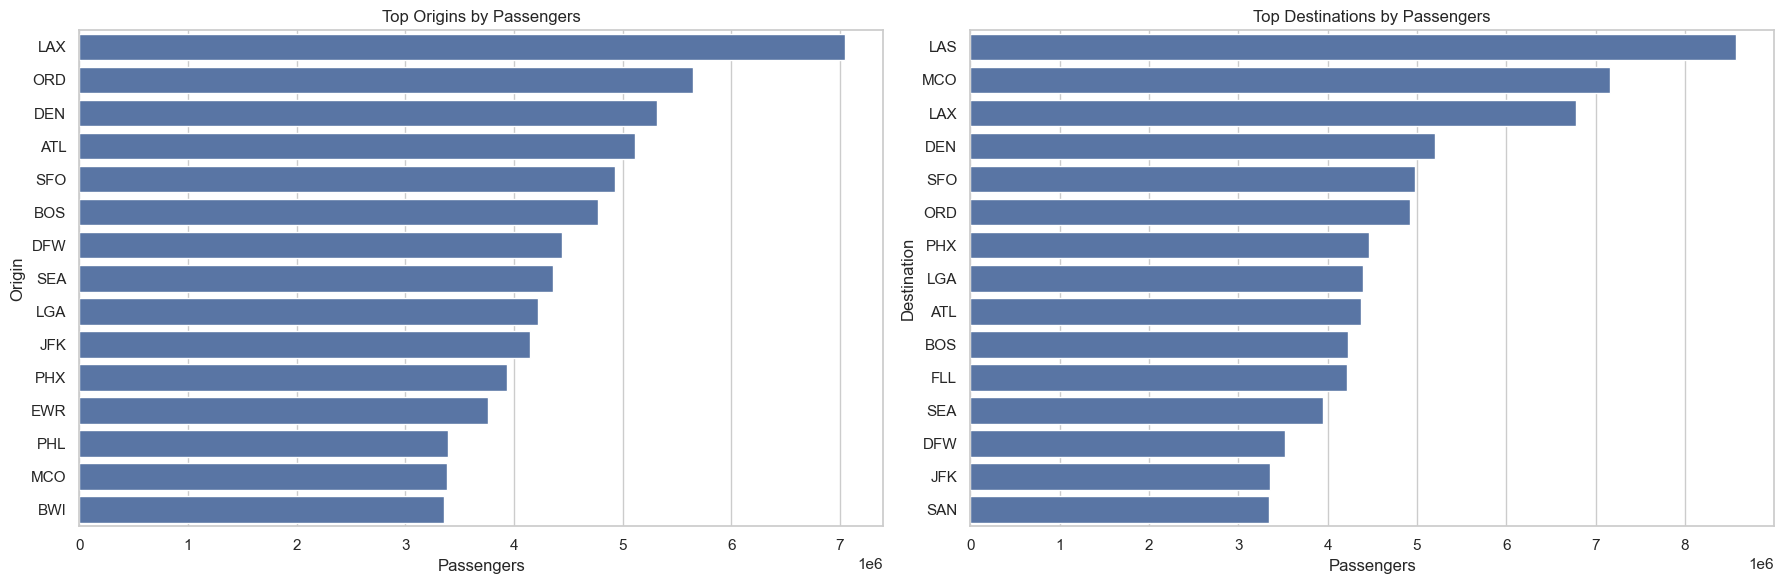

In [ ]:
    top_k = 15
    top_origin = data.groupby('origin')['passengers'].sum().nlargest(top_k).reset_index()
    top_dest = data.groupby('finaldest')['passengers'].sum().nlargest(top_k).reset_index()
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    sns.barplot(ax=axes[0], data=top_origin, x='passengers', y='origin', orient='h')
    axes[0].set_title('Top Origins by Passengers')
    axes[0].set_xlabel('Passengers')
    axes[0].set_ylabel('Origin')
    sns.barplot(ax=axes[1], data=top_dest, x='passengers', y='finaldest', orient='h')
    axes[1].set_title('Top Destinations by Passengers')
    axes[1].set_xlabel('Passengers')
    axes[1].set_ylabel('Destination')
    plt.tight_layout()
    plt.show()

This chart shows the most prominent U.S. carriers ranked by their implied passenger share across all routes.
A few major airlines clearly dominate the market: Southwest (WN) leads by a wide margin, followed by Delta (DL) and American (AA), together accounting for a substantial share of total passengers.

Mid-tier carriers like JetBlue (B6) and United (UA) maintain strong national presence, while smaller airlines such as Frontier (F9) and Spirit (NK) operate in more specialized, price-sensitive segments.

The distribution highlights how a few large carriers control the majority of U.S. air travel, shaping both competition and pricing power across markets.

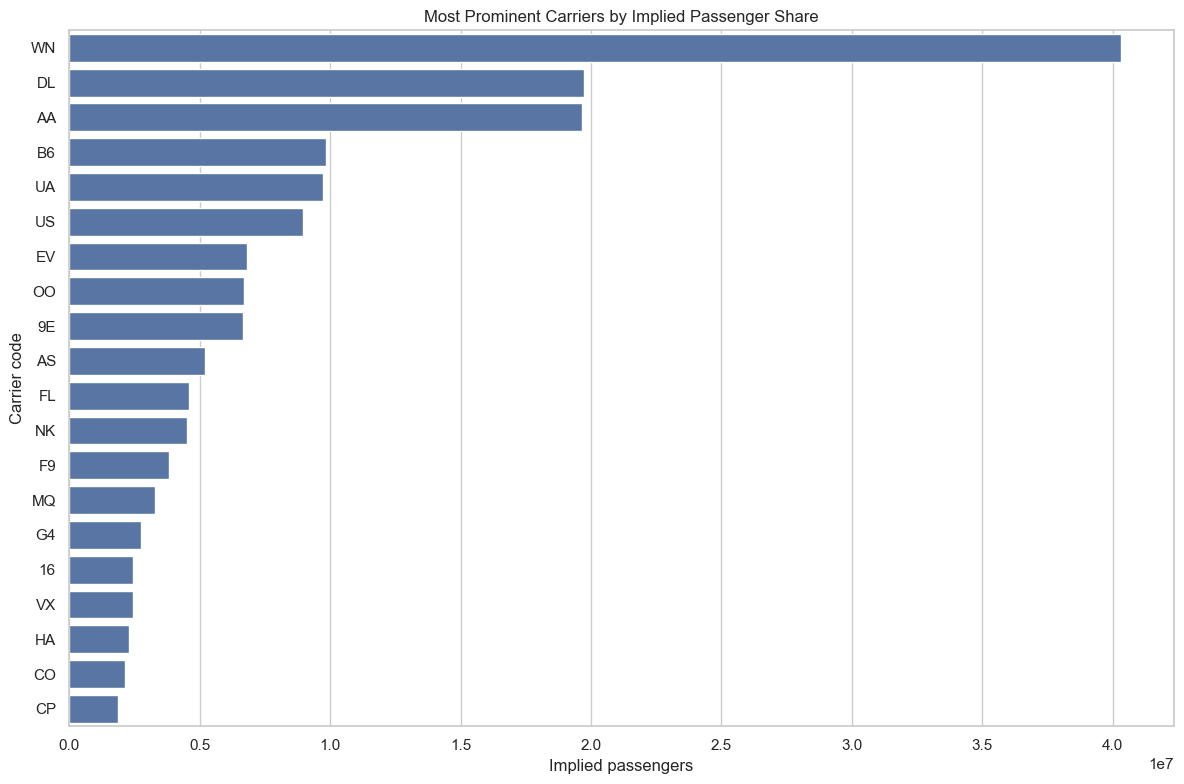

In [ ]:
share_cols = [
    c for c in data.columns 
    if c.startswith('share') 
    and c not in ['sharelargest']
]

shares = data[share_cols].copy()
max_share = shares.max().max()
scale = 100.0 if max_share > 1 else 1.0
shares01 = shares / scale

carrier_passengers = (shares01.mul(data['passengers'], axis=0)).sum().sort_values(ascending=False)
top_carriers = carrier_passengers.head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=top_carriers.values, y=[c.replace('share','') for c in top_carriers.index], orient='h')
plt.title('Most Prominent Carriers by Implied Passenger Share')
plt.xlabel('Implied passengers')
plt.ylabel('Carrier code')
plt.tight_layout()
plt.show()


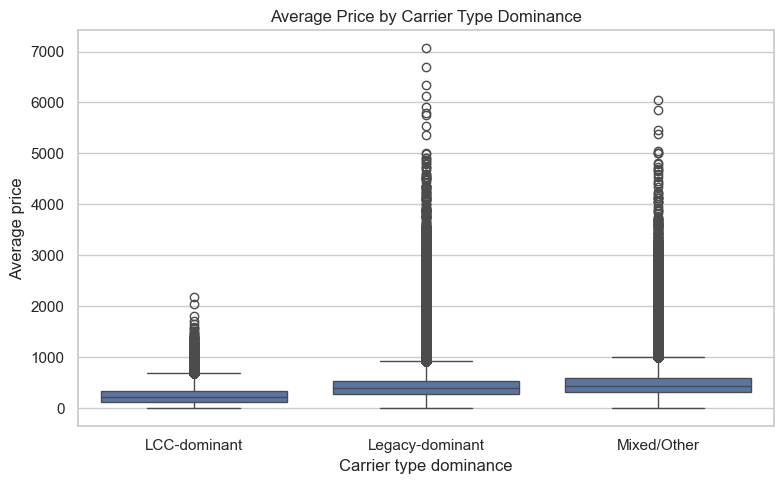

In [ ]:
# Price comparison by carrier type (LCC vs legacy)
# Map carrier codes to LCC/Legacy groups (approximate list; adjust as needed)
carrier_type_map = {
    'WN':'LCC','B6':'LCC','NK':'LCC','F9':'LCC','G4':'LCC','SY':'LCC',
    'AS':'Legacy','AA':'Legacy','DL':'Legacy','UA':'Legacy','US':'Legacy','VX':'Legacy'
}
shares = data[share_cols].copy()
scale = 100.0 if shares.max().max() > 1 else 1.0
shares01 = shares / scale
lcc_cols = [c for c in share_cols if c.replace('share','') in carrier_type_map and carrier_type_map[c.replace('share','')] == 'LCC']
legacy_cols = [c for c in share_cols if c.replace('share','') in carrier_type_map and carrier_type_map[c.replace('share','')] == 'Legacy']
data['share_LCC'] = shares01[lcc_cols].sum(axis=1) if len(lcc_cols) else 0.0
data['share_Legacy'] = shares01[legacy_cols].sum(axis=1) if len(legacy_cols) else 0.0
def dominant_type(row):
    if row['share_LCC'] > row['share_Legacy']:
        return 'LCC-dominant'
    elif row['share_Legacy'] > row['share_LCC']:
        return 'Legacy-dominant'
    else:
        return 'Mixed/Other'
data['carrier_type_dominant'] = data[['share_LCC','share_Legacy']].apply(lambda r: dominant_type({'share_LCC': r['share_LCC'], 'share_Legacy': r['share_Legacy']}), axis=1)
plt.figure(figsize=(8,5))
sns.boxplot(data=data, x='carrier_type_dominant', y='avgprice', order=['LCC-dominant','Legacy-dominant','Mixed/Other'])
plt.title('Average Price by Carrier Type Dominance')
plt.xlabel('Carrier type dominance')
plt.ylabel('Average price')
plt.tight_layout()
plt.show()


### VI. Income-Based Market Segmentation

The variable smallmkt indicates whether a route belongs to a small or low-volume market. Analyzing this dimension reveals a clear structural divide across the dataset. Routes in small markets show much higher average fares (around $430) compared to large markets (about $120). These routes also tend to have higher market concentration (HHI ≈ 13,700) and far fewer passengers, reflecting thinner demand and limited service options. While the number of carriers appears slightly higher in small markets, this likely reflects code-sharing or connecting flights rather than genuine competition. The fare distribution supports this interpretation: large markets cluster around low prices, while small markets display a wide, right-skewed spread with many high-priced outliers. Overall, small or low-volume markets are less competitive and substantially more expensive, aligning with expected economic patterns in concentrated airline markets.


,avgprice,stops,n_carriers,hhi,passengers
smallmkt,,,,,
False,121.86,0.98,2.53,10007.27,2600.86
True,432.83,1.17,4.50,13686.49,48.67


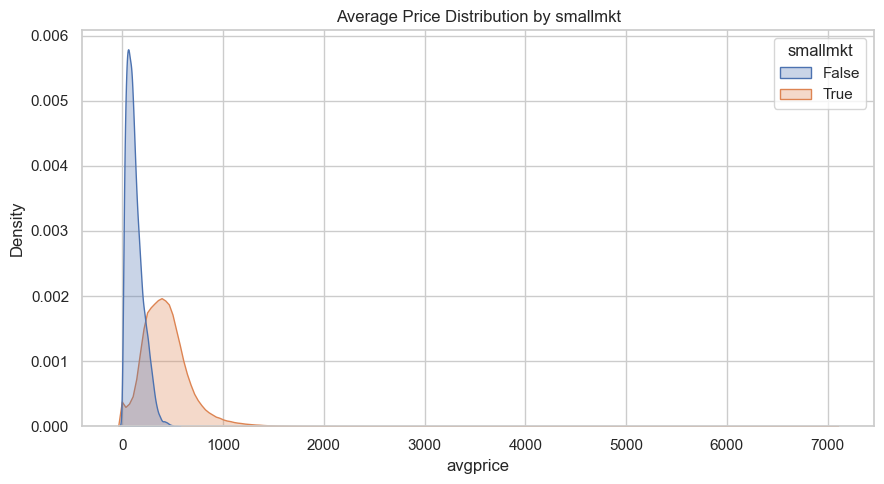

In [ ]:
metrics = [c for c in ['avgprice','stops','n_carriers','hhi','passengers'] if c in data.columns]
comp = data.groupby('smallmkt')[metrics].mean().round(2)
display(comp)

plt.figure(figsize=(9,5))
sns.kdeplot(data=data, x='avgprice', hue='smallmkt', common_norm=False, fill=True, alpha=0.3)
plt.title('Average Price Distribution by smallmkt')
plt.tight_layout()
plt.show()

### VII. Correlation and Feature Relationships

The scatterplots below explore how average fares relate to market size, competition, and carrier type. Prices tend to fall as passenger volumes increase, confirming economies of scale on busy routes. The relationship with the number of carriers and HHI highlights that competition affects fares nonlinearly—markets with fewer carriers or higher concentration often charge more. Finally, routes dominated by low-cost carriers (LCCs) generally exhibit lower average fares, consistent with price competition from budget airlines.

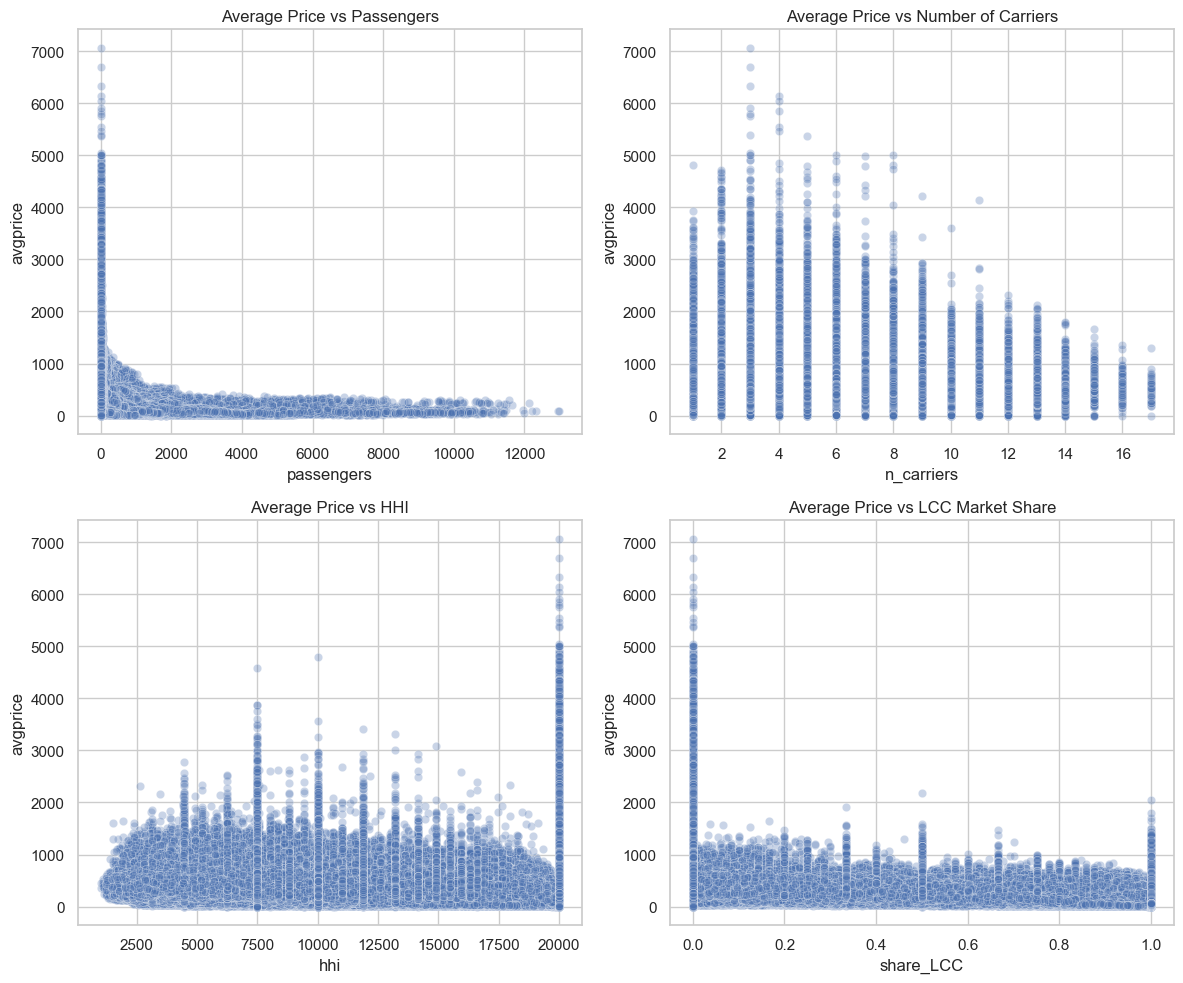

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(ax=axes[0,0], data=data, x='passengers', y='avgprice', alpha=0.3)
axes[0,0].set_title('Average Price vs Passengers')

sns.scatterplot(ax=axes[0,1], data=data, x='n_carriers', y='avgprice', alpha=0.3)
axes[0,1].set_title('Average Price vs Number of Carriers')

sns.scatterplot(ax=axes[1,0], data=data, x='hhi', y='avgprice', alpha=0.3)
axes[1,0].set_title('Average Price vs HHI')

sns.scatterplot(ax=axes[1,1], data=data, x='share_LCC', y='avgprice', alpha=0.3)
axes[1,1].set_title('Average Price vs LCC Market Share')

plt.tight_layout()
plt.show()

The correlation matrix highlights how average fares relate to demand, competition, and route structure. Fares are moderately correlated with number of stops and airports, suggesting that more complex itineraries drive higher prices. The strong correlation between HHI and sharelargest confirms they capture similar market concentration effects. Passenger volume is negatively correlated with avgprice, consistent with lower fares in high-traffic markets. Overall, these relationships support economic expectations—competition and scale lower prices, while concentration and route complexity increase them.

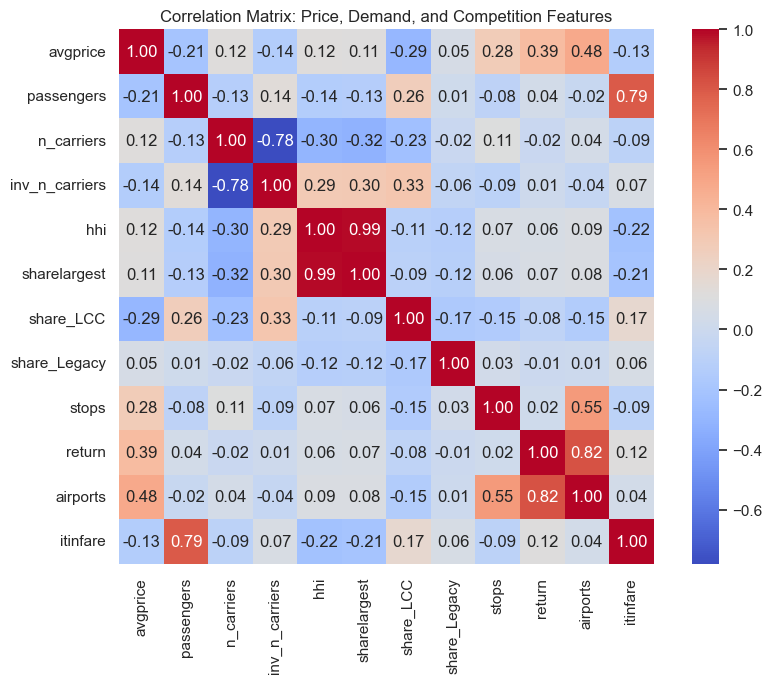

In [ ]:
corr_cols = [
    'avgprice',
    'passengers',
    'n_carriers',
    'inv_n_carriers',
    'hhi',
    'sharelargest',
    'share_LCC',
    'share_Legacy',
    'stops',
    'return',
    'airports',
    'itinfare'
]

corr = data[corr_cols].corr(method='pearson')
corr.round(2)

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix: Price, Demand, and Competition Features')
plt.tight_layout()
plt.show()

The correlation matrix highlights how average fares relate to demand, competition, and route structure. Fares are moderately correlated with number of stops and airports, suggesting that more complex itineraries drive higher prices. The strong correlation between HHI and sharelargest confirms they capture similar market concentration effects. Passenger volume is negatively correlated with avgprice, consistent with lower fares in high-traffic markets. Overall, these relationships support economic expectations—competition and scale lower prices, while concentration and route complexity increase them.

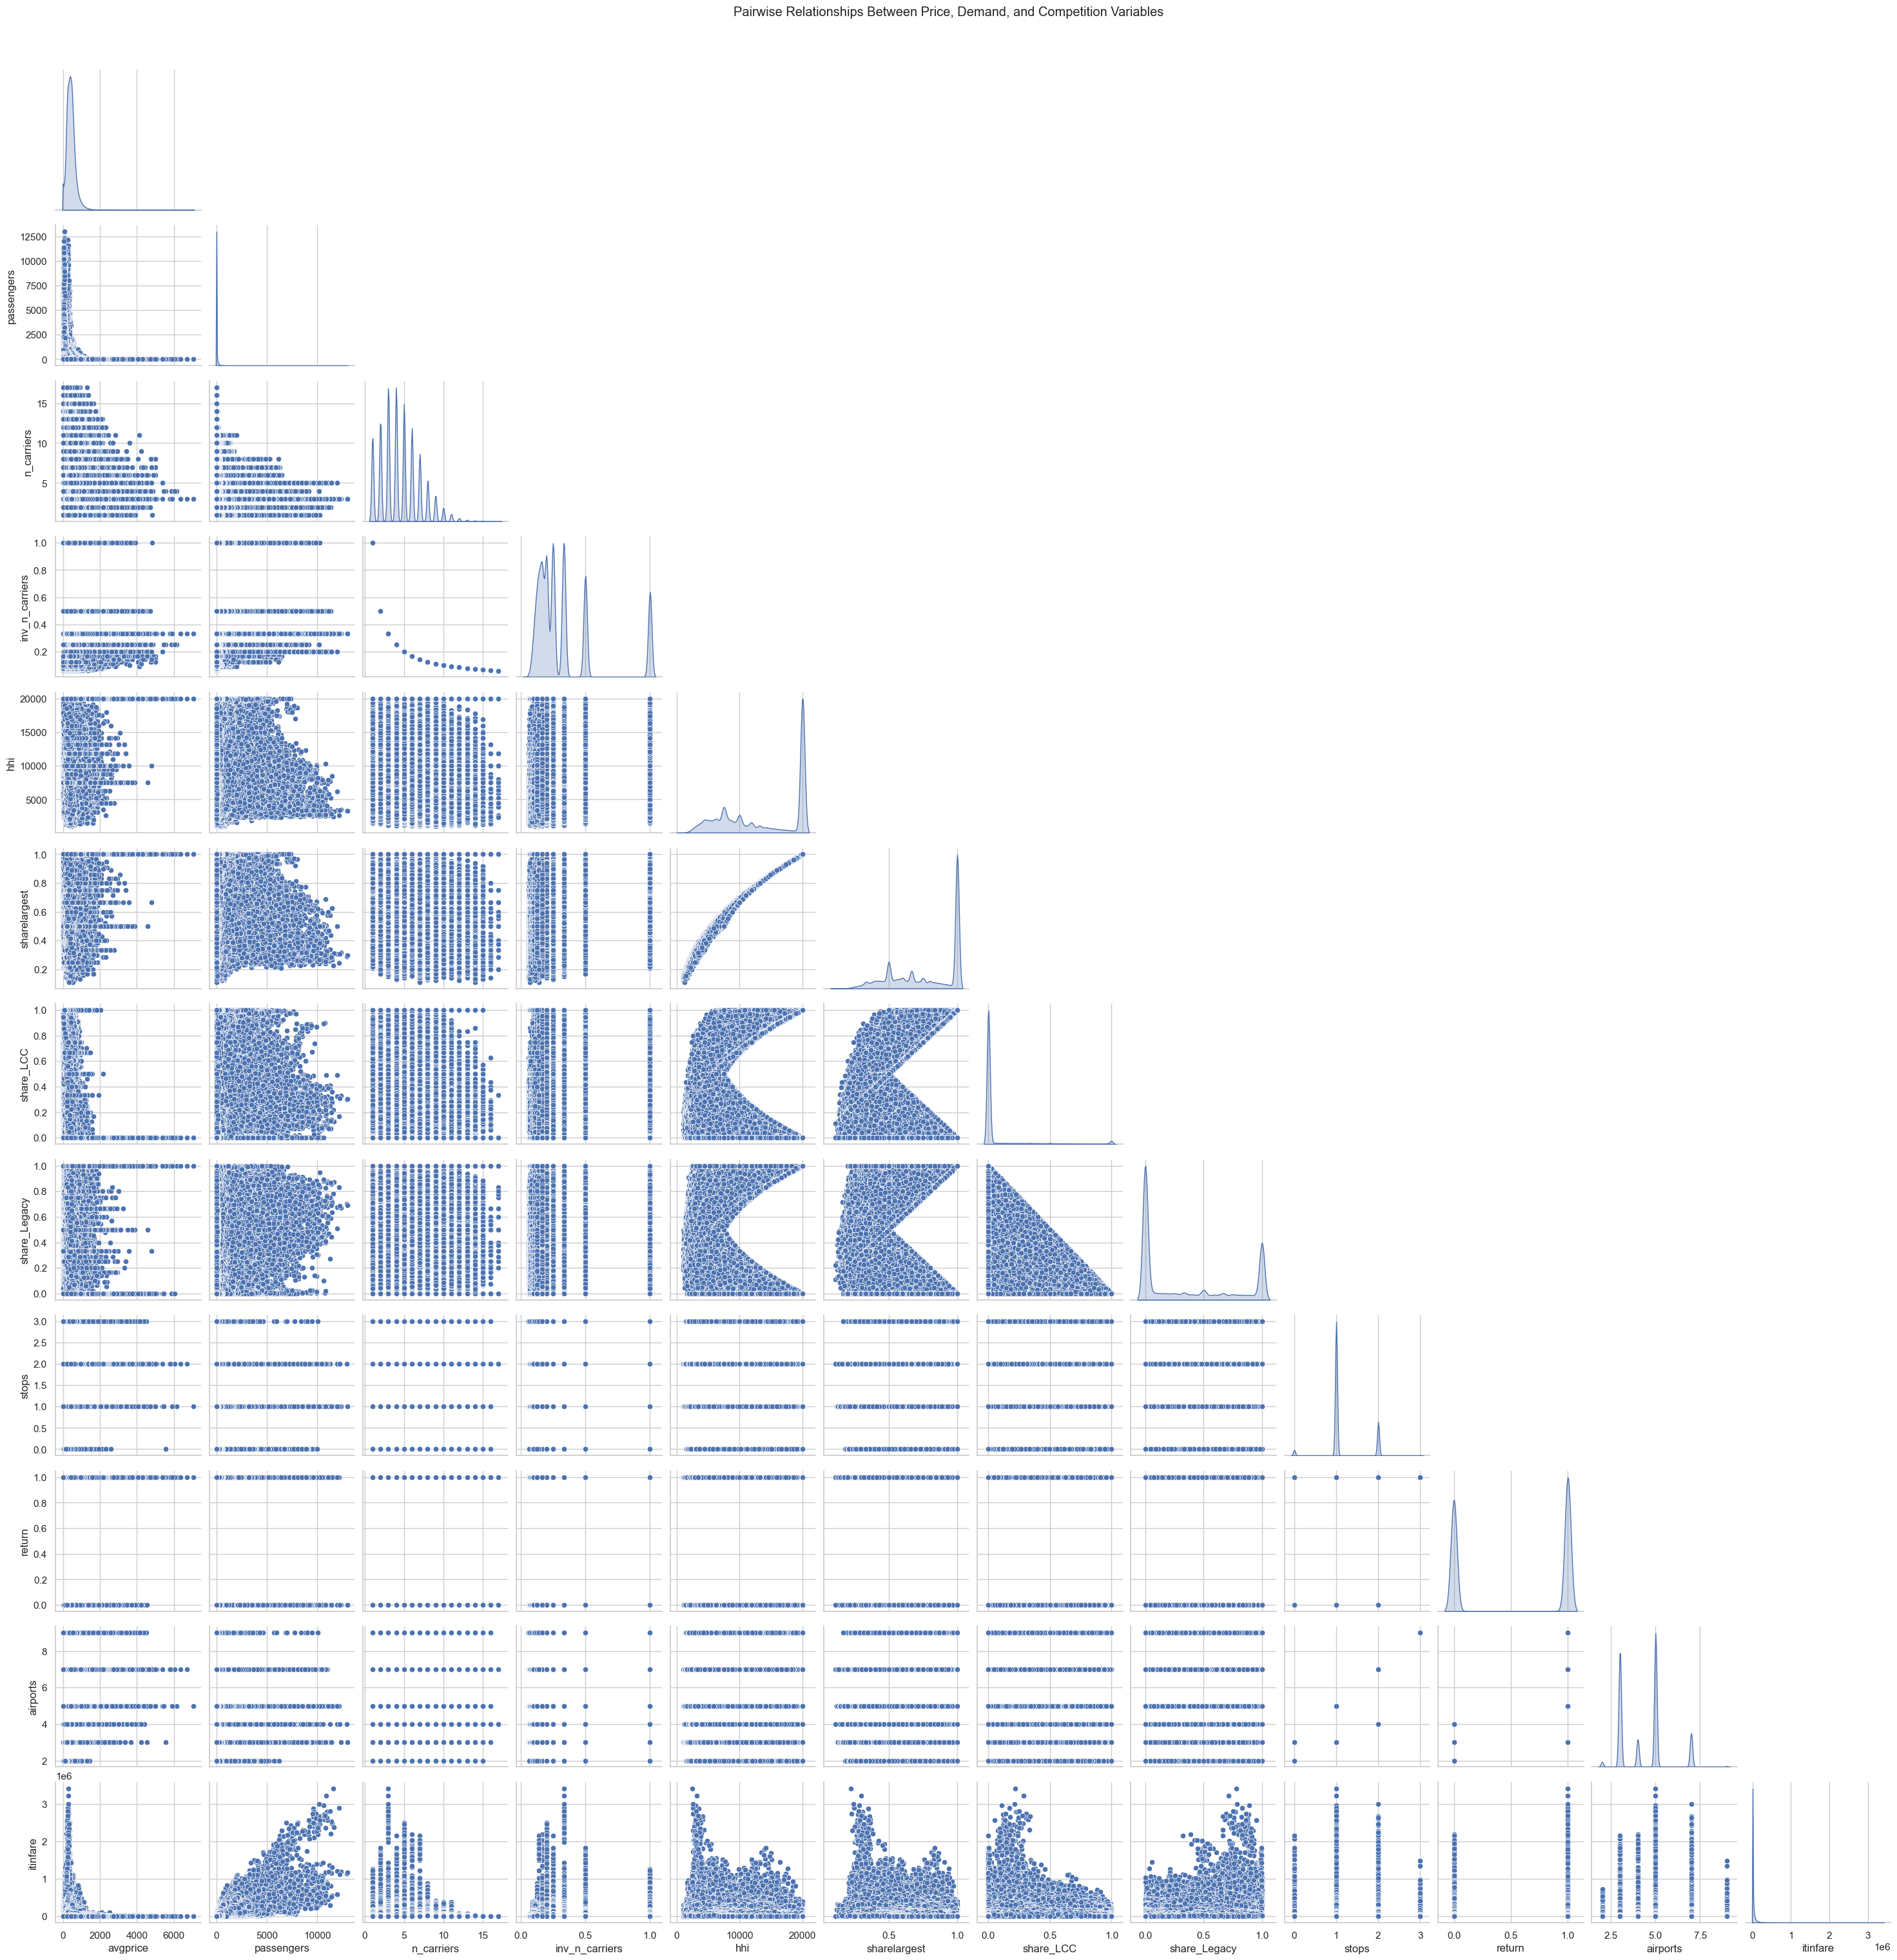

In [ ]:
sns.pairplot(data[corr.columns], diag_kind='kde', corner=True)
plt.suptitle("Pairwise Relationships Between Price, Demand, and Competition Variables", y=1.02)
plt.show()

To check for multicollinearity among explanatory variables, I calculated the Variance Inflation Factor (VIF) for key features: passenger volume, number of carriers, stops, and market concentration (HHI). All VIF values are close to 1, indicating that these predictors are largely independent and suitable for inclusion in regression analysis. The high constant term is expected and does not affect model interpretability.

In [ ]:
vif_features = [c for c in ['passengers','n_carriers','stops','hhi'] if c in data.columns]
if len(vif_features) >= 2:
    X = data[vif_features].dropna().sample(min(100000, data[vif_features].dropna().shape[0]), random_state=42)
    X = sm.add_constant(X)
    vif = pd.DataFrame({
        'feature': X.columns,
        'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    display(vif)

,feature,VIF
0,const,18.297005
1,passengers,1.055181
2,n_carriers,1.154916
3,stops,1.025150
4,hhi,1.153763


### Summary & Next Steps


This exploratory analysis provides a comprehensive view of how market structure and competition dynamics shape airline pricing patterns:

* Fares increase with market concentration (higher HHI) and tend to be lower on routes with more carriers, highlighting the expected relationship between competition and pricing power.
* Low-cost carrier (LCC) dominance corresponds to systematically lower average fares, whereas legacy-dominated markets exhibit higher price levels.
* Small or low-volume markets show distinct distributions—often higher fares and fewer carriers—reflecting limited competition and demand constraints.
* Correlation and VIF analyses confirm that the selected explanatory variables (competition, demand, and structural features) are not strongly collinear and are suitable for regression modeling.

Next Steps:

* Develop regression models to formally test price–competition relationships using avgprice as the dependent variable and predictors such as n_carriers, hhi, stops, and market type indicators.
* Introduce route and time fixed effects to control for unobserved heterogeneity.
* Apply robust or clustered standard errors and perform sensitivity checks using alternative competition metrics and subsets of the data (e.g., by year or market size).